In [51]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
import json
from scipy.ndimage.filters import gaussian_filter
import shutil
%matplotlib inline

In [2]:
plt.rcParams.update({'font.size': 20})

In [3]:
root_directory = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset'

# Load Meanbrain


~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 269.20 ms


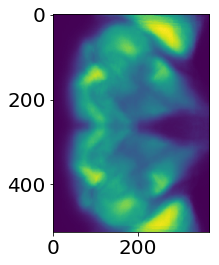

In [4]:
file = os.path.join(root_directory, '2019_nov_meanbrain', 'meanbrain_final.nii')
meanbrain = bbb.load_numpy_brain(file)
meanbrain = ants.from_numpy(meanbrain)
anatomy_xml = os.path.join(root_directory, 'fly_25', 'anat_0', 'anatomy.xml')
meanbrain.set_spacing(bbb.get_resolution(anatomy_xml))
plt.imshow(meanbrain.numpy()[:,:,150])

# Load Anatomies

In [5]:
flies = ['fly_1',
         'fly_3',
         'fly_5',
         'fly_7',
         'fly_19',
         'fly_21',
         'fly_48',
         'fly_51',
         'fly_54',
         'fly_68']

anatomy = {}

for fly in flies:
    anat_folder = os.path.join(root_directory, fly, 'anat_0')
    try:
        anatomy[fly] = bbb.load_numpy_brain(os.path.join(anat_folder, 'anatomy_channel_1.nii'))
        print('Loaded {}'.format(fly))
    except:
        print('failed to load anatomy_channel_1.nii: {}'.format(fly))
        try:
            anatomy[fly] = bbb.load_numpy_brain(os.path.join(anat_folder, 'anatomy.nii'))
        except:
            print('failed to load anatomy.nii: {}'.format(fly))


~~ load_numpy_brain ~~
failed to load anatomy_channel_1.nii: fly_1

~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 470.08 ms

~~ load_numpy_brain ~~
failed to load anatomy_channel_1.nii: fly_3

~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 346.70 ms

~~ load_numpy_brain ~~
failed to load anatomy_channel_1.nii: fly_5

~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 205.82 ms

~~ load_numpy_brain ~~
failed to load anatomy_channel_1.nii: fly_7

~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 484.72 ms

~~ load_numpy_brain ~~
failed to load anatomy_channel_1.nii: fly_19

~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 319.04 ms

~~ load_numpy_brain ~~
failed to load anatomy_channel_1.nii: fly_21

~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 214.55 ms

~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 204.56 ms
Loaded fly_48

~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 227.96 ms
Loaded fly_51

~~ load_numpy_brain ~~
lo

In [6]:
to_rotate = ['fly_1', 'fly_7']
for k in to_rotate:
    anatomy[k] = np.swapaxes(anatomy[k],0,1)

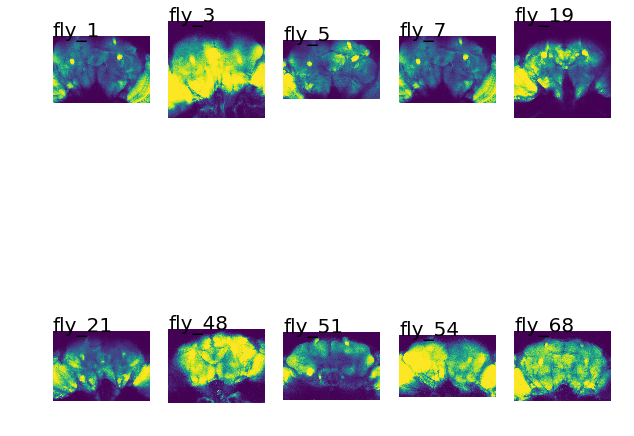

In [7]:
plt.figure(figsize=(10,10))
for i,k in enumerate(anatomy):
    plt.subplot(2,5,i+1)
    plt.imshow(anatomy[k][:,:,100].T)
    plt.axis('off')
    plt.text(0,0,k)

In [8]:
anatomy_ants = {}
for anat in anatomy:
    anatomy_xml = os.path.join(root_directory, anat, 'anat_0', 'anatomy.xml')
    anatomy_ants[anat] = ants.from_numpy(anatomy[anat])
    anatomy_ants[anat].set_spacing(bbb.get_resolution(anatomy_xml))
    print('DONE: {}'.format(anat))

DONE: fly_1
DONE: fly_3
DONE: fly_5
DONE: fly_7
DONE: fly_19
DONE: fly_21
DONE: fly_48
DONE: fly_51
DONE: fly_54
DONE: fly_68


# Warp individual2mean

In [9]:
master = meanbrain
anatomy_warps = {}

#for anat in ['fly_48']:
for anat in anatomy_ants:

    print('Working on {}'.format(anat))
    t0 = time.time()
    slave = anatomy_ants[anat]
    anatomy_warps[anat] = ants.registration(master,slave,type_of_transform='SyN')
    print('COMPLETE. Duration: {:0.0f} sec'.format(time.time()-t0))

Working on fly_1
COMPLETE. Duration: 193 sec
Working on fly_3
COMPLETE. Duration: 205 sec
Working on fly_5
COMPLETE. Duration: 188 sec
Working on fly_7
COMPLETE. Duration: 193 sec
Working on fly_19
COMPLETE. Duration: 202 sec
Working on fly_21
COMPLETE. Duration: 195 sec
Working on fly_48
COMPLETE. Duration: 198 sec
Working on fly_51
COMPLETE. Duration: 201 sec
Working on fly_54
COMPLETE. Duration: 215 sec
Working on fly_68
COMPLETE. Duration: 197 sec


# Save warp transforms

In [15]:
anatomy_warps['fly_48']

{'fwdtransforms': ['/tmp/tmpys_l3qd11Warp.nii.gz',
  '/tmp/tmpys_l3qd10GenericAffine.mat'],
 'invtransforms': ['/tmp/tmpys_l3qd10GenericAffine.mat',
  '/tmp/tmpys_l3qd11InverseWarp.nii.gz'],
 'warpedfixout': ANTsImage (RAI)
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (512, 392, 241)
 	 Spacing    : (0.768, 0.768, 1.0)
 	 Origin     : (0.0, 0.0, 0.0)
 	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.],
 'warpedmovout': ANTsImage (RAI)
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (512, 368, 251)
 	 Spacing    : (0.768, 0.768, 1.0)
 	 Origin     : (0.0, 0.0, 0.0)
 	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]}

In [12]:
for fly in flies:
    transforms = anatomy_warps[fly]['fwdtransforms']
    for transform in transforms:
        file = os.path.split(transform)[-1]
        move_to_dir = os.path.join(root_directory, fly, 'anat_0', 'anat2mean_20191107')
        if not os.path.exists(move_to_dir):
            os.mkdir(move_to_dir)
        move_to_file = os.path.join(move_to_dir, file)
        shutil.copy(transform, move_to_file)

In [ ]:
warp_applied = ants.apply_transforms(meanbrain,
                                   anatomy_ants['fly_48'],
                                   anatomy_warps['fly_48']['fwdtransforms'])

# We also need to warp func2anat!!!

# Load func_means

In [28]:
func_means = {}
for fly in flies:
    try:
        file = os.path.join(root_directory, fly, 'func_0', 'imaging', 'functional_channel_1_mean.nii')
        func_means[fly] = bbb.load_numpy_brain(file)
        print('LOADED 1st: {}'.format(fly))
    except:
        try:
            file = os.path.join(root_directory, fly, 'func_0', 'imaging', 'functional_mean.nii')
            func_means[fly] = bbb.load_numpy_brain(file)
            print('LOADED 2nd: {}'.format(fly))
        except:
            print('Creating meanbrain: {}'.format(fly))
            file = os.path.join(root_directory, fly, 'func_0', 'imaging', 'functional.nii')
            brain = bbb.load_numpy_brain(file)
            if brain.ndim == 5:
                meanbrain = np.mean(brain[:,:,:,:,0],axis=-1)
            else:
                meanbrain = np.mean(brain,axis=-1)
            func_means[fly] = meanbrain
            print('DONE: {}'.format(fly))


~~ load_numpy_brain ~~

~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 61.44 ms
LOADED 2nd: fly_1

~~ load_numpy_brain ~~

~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 11.89 ms
LOADED 2nd: fly_3

~~ load_numpy_brain ~~

~~ load_numpy_brain ~~
Creating meanbrain: fly_5

~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 11.94 sec
DONE: fly_5

~~ load_numpy_brain ~~

~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 13.85 ms
LOADED 2nd: fly_7

~~ load_numpy_brain ~~

~~ load_numpy_brain ~~
Creating meanbrain: fly_19

~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 24.29 sec
DONE: fly_19

~~ load_numpy_brain ~~

~~ load_numpy_brain ~~
Creating meanbrain: fly_21

~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 23.99 sec
DONE: fly_21

~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 7.62 ms
LOADED 1st: fly_48

~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 6.24 ms
LOADED 1st: fly_51

~~ load_numpy_brain ~~
load_numpy_brain done

In [35]:
to_rotate = ['fly_1', 'fly_3', 'fly_7']
for fly in to_rotate:
    func_means[fly] = np.swapaxes(func_means[fly],0,1)

In [43]:
to_flip_z = ['fly_1', 'fly_3', 'fly_7']
for fly in to_flip_z:
    func_means[fly] = func_means[fly][:,:,::-1]

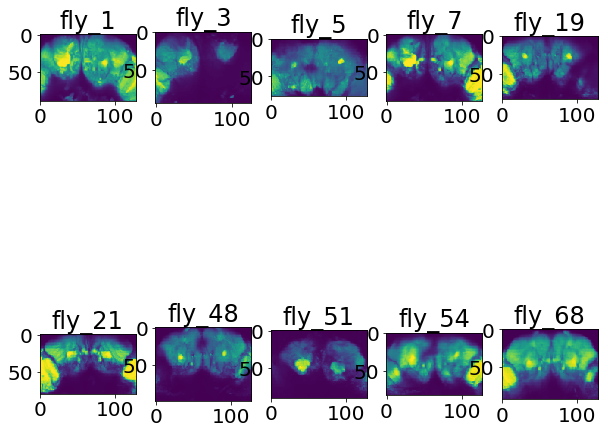

In [48]:
plt.figure(figsize=(10,10))
for i,fly in enumerate(flies):
    #print(fly, func_means[fly].ndim)
    plt.subplot(2,5,i+1)
    plt.imshow(func_means[fly][:,:,12].T)
    plt.title(fly)

In [69]:
func_mean_ants = {}
for fly in func_means:
    metadata_file = os.path.join(root_directory, fly, 'func_0', 'imaging', 'scan.json')
    with open(metadata_file) as json_file:
        metadata = json.load(json_file)
    spacing = (metadata['x_voxel_size'], metadata['y_voxel_size'], metadata['z_voxel_size'])
    func_mean_ants[fly] = ants.from_numpy(func_means[fly])
    func_mean_ants[fly].set_spacing(spacing)
    print('DONE: {}'.format(fly))
    #anatomy_ants[anat] = ants.from_numpy(anatomy[anat])
    #anatomy_ants[anat].set_spacing(bbb.get_resolution(anatomy_xml))
    #print('DONE: {}'.format(anat))

DONE: fly_1
DONE: fly_3
DONE: fly_5
DONE: fly_7
DONE: fly_19
DONE: fly_21
DONE: fly_48
DONE: fly_51
DONE: fly_54
DONE: fly_68


In [71]:
func_mean_ants

{'fly_1': ANTsImage (RAI)
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (128, 88, 55)
 	 Spacing    : (2.9013, 2.9013, 5.0)
 	 Origin     : (0.0, 0.0, 0.0)
 	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.], 'fly_19': ANTsImage (RAI)
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (128, 84, 49)
 	 Spacing    : (3.072, 3.072, 5.0)
 	 Origin     : (0.0, 0.0, 0.0)
 	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.], 'fly_21': ANTsImage (RAI)
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (128, 79, 53)
 	 Spacing    : (3.072, 3.072, 5.0)
 	 Origin     : (0.0, 0.0, 0.0)
 	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.], 'fly_3': ANTsImage (RAI)
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (126, 94, 53)
 	 Spacing    : (2.9013, 2.9013, 5.0)
 	 Origin     : (0.0, 0.0, 0.0)
 	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.], 'fly_48': ANTsImage (RAI)
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (128, 98, 43)
 	 Spacing 

# Align func2anat

In [70]:
# we have func_mean_ants and anatomy_ants
func2anat = {}
for fly in anatomy_ants:
    master = anatomy_ants[fly]
    slave = func_mean_ants[fly]
    func2anat[fly] = ants.registration(master,slave,'AffineFast')
    print('DONE: {}'.format(fly))

DONE: fly_1
DONE: fly_3
DONE: fly_5
DONE: fly_7
DONE: fly_19
DONE: fly_21
DONE: fly_48
DONE: fly_51
DONE: fly_54
DONE: fly_68


### Save warp params

In [73]:
for fly in flies:
    transforms = func2anat[fly]['fwdtransforms']
    for transform in transforms:
        file = os.path.split(transform)[-1]
        move_to_dir = os.path.join(root_directory, fly, 'anat_0', 'func2anat_20191107')
        
        # Need to first delete incorrect files
        [os.remove(os.path.join(move_to_dir,file)) for file in os.listdir(move_to_dir)]
        
        #if not os.path.exists(move_to_dir):
        #    os.mkdir(move_to_dir)
        move_to_file = os.path.join(move_to_dir, file)
        shutil.copy(transform, move_to_file)

### Remember, for fwd, it is .nii then .mat

# Save warped brains

In [ ]:
for fly in anatomy_warps:
    save_file = os.path.join(root_directory, fly, 'anat_0', '20191107_quicktest_directwarp.nii')
    bbb.save_brain(save_file, anatomy_warps[fly]['warpedmovout'].numpy())


~~ save_brain ~~


KeyboardInterrupt: 

In [15]:
matrix = []
for fly in anatomy_warps:
    matrix.append(anatomy_warps[fly]['warpedmovout'].numpy())

In [17]:
meanaligned = np.mean(matrix,axis=0)

In [ ]:
DONE: fly_1
DONE: fly_3
DONE: fly_5
DONE: fly_7
DONE: fly_19
DONE: fly_21
DONE: fly_48
DONE: fly_51
DONE: fly_54
DONE: fly_68

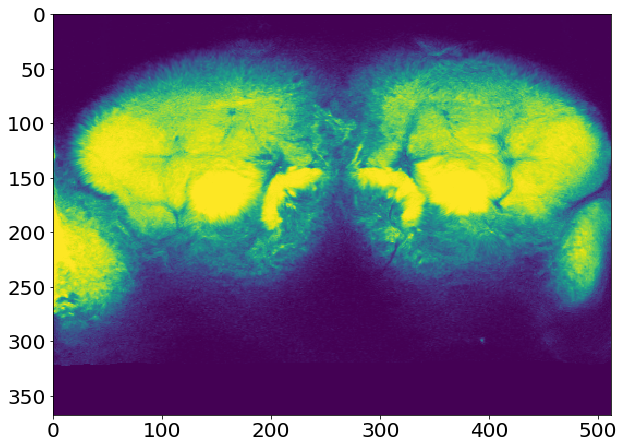

In [47]:
plt.figure(figsize=(10,10))
plt.imshow(anatomy_warps['fly_68']['warpedmovout'].numpy()[:,:,85].T)

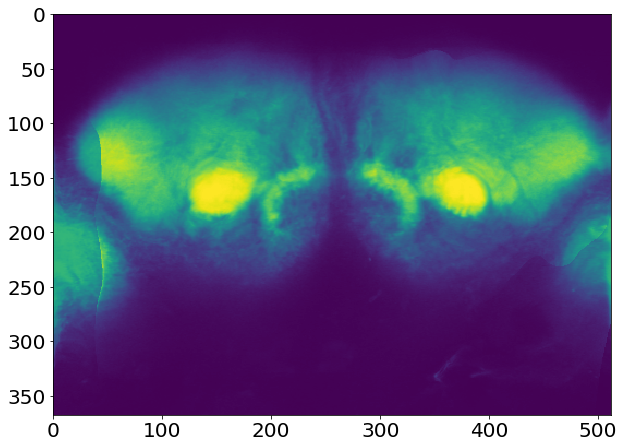

In [48]:
plt.figure(figsize=(10,10))
plt.imshow(meanaligned[:,:,85].T)